# A/B Testing + SQL Integration Notebook

## **Project Overview**
We are analyzing user behavior for two Megaline plans: **Surf** (control) and **Ultra** (test).  
The goal is to determine:
- Which plan drives better **conversion rate (CR)** and **average revenue per user (ARPU)**.
- Whether the difference in ARPU is **statistically significant**.

---

## **Steps**
1. **Connect to the SQL database** (`megaline_db`).  
2. **Query user behavior** to extract metrics (calls, minutes, messages, MB used).  
3. **Calculate monthly usage and revenue** for each plan.  
4. **Perform A/B testing**:  
   - Compare CR and ARPU for Surf vs Ultra.  
   - Use t-tests to check ARPU differences.  
5. **Visualize metrics** with bar charts.  
6. **Generate insights and recommendations**.

In [13]:
!python load_megaline_data.ipynb

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [15]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [16]:
# Connect to MySQL
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="September97!",
    database="megaline_db"
)

# Preview Data
print("Quick Preview of users_behavior Table:")
preview_df = pd.read_sql("SELECT * FROM users_behavior LIMIT 10;", conn)
display(preview_df)


Quick Preview of users_behavior Table:


/var/folders/p3/43px2jb159dgb_cp9t6gw27h0000gn/T/ipykernel_38321/3331883481.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  preview_df = pd.read_sql("SELECT * FROM users_behavior LIMIT 10;", conn)


,user_id,calls,minutes,messages,mb_used,is_ultra
0,0,40,311.90,83,19915.40,0
1,1,85,516.75,56,22697.00,0
2,2,77,467.66,86,21060.40,0
3,3,106,745.53,81,8437.39,1
4,4,66,418.74,1,14502.80,0
5,5,58,344.56,21,15823.40,0
6,6,57,431.64,20,3738.90,1
7,7,15,132.40,6,21911.60,0
8,8,7,43.39,3,2538.67,1
9,9,90,665.41,38,17358.60,0


/var/folders/p3/43px2jb159dgb_cp9t6gw27h0000gn/T/ipykernel_38321/3216617604.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  monthly_usage_df = pd.read_sql(monthly_usage_query, conn)


,user_id,total_calls,total_minutes,total_messages,total_mb
0,0,80.0,623.799988,166.0,39830.839844
1,1,170.0,1033.500000,112.0,45393.921875
2,2,154.0,935.320007,172.0,42120.898438
3,3,212.0,1491.060059,162.0,16874.779297
4,4,132.0,837.479980,2.0,29005.500000


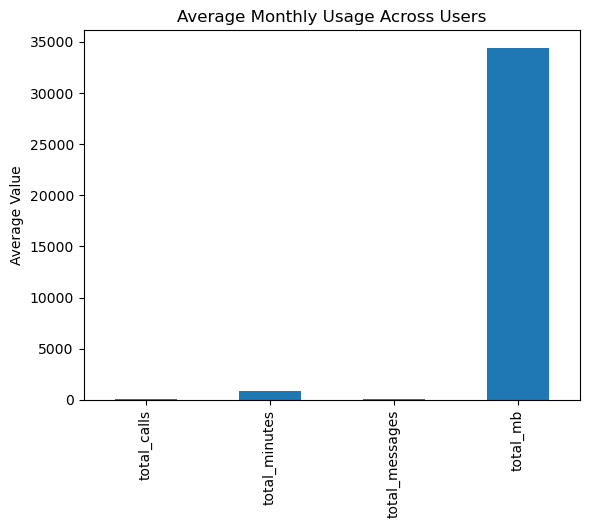

In [17]:
# Monthly Usage Metrics
monthly_usage_query = """
SELECT 
    user_id,
    SUM(calls) AS total_calls,
    SUM(minutes) AS total_minutes,
    SUM(messages) AS total_messages,
    SUM(mb_used) AS total_mb
FROM users_behavior
GROUP BY user_id;
"""
monthly_usage_df = pd.read_sql(monthly_usage_query, conn)
display(monthly_usage_df.head())

# Visualization: Average Monthly Usage
monthly_usage_df[['total_calls', 'total_minutes', 'total_messages', 'total_mb']].mean().plot(kind='bar')
plt.title("Average Monthly Usage Across Users")
plt.ylabel("Average Value")
plt.show()

In [18]:
# Revenue 
revenue_query = """
SELECT 
    is_ultra,
    SUM(minutes * 0.10 + messages * 0.05 + mb_used * 0.01) AS total_revenue
FROM users_behavior
GROUP BY is_ultra;
"""
revenue_df = pd.read_sql(revenue_query, conn)
display(revenue_df)

/var/folders/p3/43px2jb159dgb_cp9t6gw27h0000gn/T/ipykernel_38321/2292661696.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  revenue_df = pd.read_sql(revenue_query, conn)


,is_ultra,total_revenue
0,0,910984.124394
1,1,489109.357340


In [19]:
# A/B Metrics (Surf vs Ultra)

ab_metrics_query = """
SELECT 
    is_ultra,
    COUNT(user_id) AS total_users,
    SUM(CASE WHEN minutes > 0 OR messages > 0 OR mb_used > 0 THEN 1 ELSE 0 END) AS active_users,
    ROUND(SUM(CASE WHEN minutes > 0 OR messages > 0 OR mb_used > 0 THEN 1 ELSE 0 END) / COUNT(user_id), 4) AS conversion_rate,
    ROUND(SUM(minutes * 0.10 + messages * 0.05 + mb_used * 0.01) / COUNT(user_id), 2) AS ARPU
FROM users_behavior
GROUP BY is_ultra;
"""
ab_metrics_df = pd.read_sql(ab_metrics_query, conn)
print("\nA/B Metrics (Surf vs Ultra):")
display(ab_metrics_df)


A/B Metrics (Surf vs Ultra):


/var/folders/p3/43px2jb159dgb_cp9t6gw27h0000gn/T/ipykernel_38321/3106249240.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ab_metrics_df = pd.read_sql(ab_metrics_query, conn)


,is_ultra,total_users,active_users,conversion_rate,ARPU
0,0,4458,4458.0,1.0,204.35
1,1,1970,1970.0,1.0,248.28


In [20]:
# Hypothesis Testing (ARPU)

# Extract revenue data for Surf (0) and Ultra (1)
surf_revenue = pd.read_sql("""
SELECT (minutes * 0.10 + messages * 0.05 + mb_used * 0.01) AS revenue
FROM users_behavior
WHERE is_ultra = 0;
""", conn)

ultra_revenue = pd.read_sql("""
SELECT (minutes * 0.10 + messages * 0.05 + mb_used * 0.01) AS revenue
FROM users_behavior
WHERE is_ultra = 1;
""", conn)

# Perform t-test
t_stat, p_val = stats.ttest_ind(surf_revenue['revenue'], ultra_revenue['revenue'], equal_var=False)
print(f"T-Test for ARPU: t={t_stat:.3f}, p={p_val:.4f}")

if p_val < 0.05:
    print("Result: Statistically significant difference in ARPU between Surf and Ultra plans.")
else:
    print("Result: No significant difference in ARPU between Surf and Ultra plans.")


T-Test for ARPU: t=-16.282, p=0.0000
Result: Statistically significant difference in ARPU between Surf and Ultra plans.


/var/folders/p3/43px2jb159dgb_cp9t6gw27h0000gn/T/ipykernel_38321/848597191.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  surf_revenue = pd.read_sql("""
/var/folders/p3/43px2jb159dgb_cp9t6gw27h0000gn/T/ipykernel_38321/848597191.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ultra_revenue = pd.read_sql("""


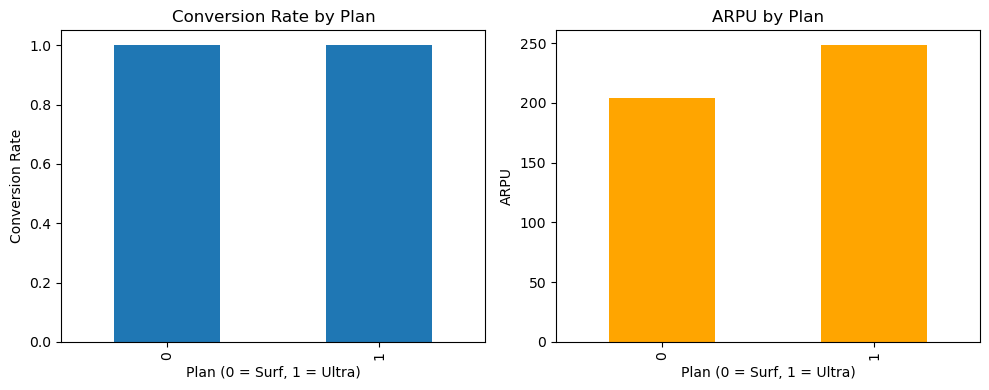

In [21]:
# Visualization

# Conversion rate and ARPU comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ab_metrics_df.plot(x='is_ultra', y='conversion_rate', kind='bar', ax=axes[0], legend=False)
axes[0].set_title('Conversion Rate by Plan')
axes[0].set_xlabel('Plan (0 = Surf, 1 = Ultra)')
axes[0].set_ylabel('Conversion Rate')

ab_metrics_df.plot(x='is_ultra', y='ARPU', kind='bar', ax=axes[1], color='orange', legend=False)
axes[1].set_title('ARPU by Plan')
axes[1].set_xlabel('Plan (0 = Surf, 1 = Ultra)')
axes[1].set_ylabel('ARPU')

plt.tight_layout()
plt.show()

In [22]:
# Insights Generator
def generate_insights(ab_df, t_p_val):
    surf_data = ab_df[ab_df['is_ultra'] == 0].iloc[0]
    ultra_data = ab_df[ab_df['is_ultra'] == 1].iloc[0]

    surf_cr = surf_data['conversion_rate']
    ultra_cr = ultra_data['conversion_rate']
    surf_arpu = surf_data['ARPU']
    ultra_arpu = ultra_data['ARPU']

    cr_diff = (ultra_cr - surf_cr) * 100  # percentage difference
    arpu_diff = ultra_arpu - surf_arpu

    print("\n=== Insights & Recommendations ===")
    print(f"- Surf Plan: Conversion Rate = {surf_cr:.2%}, ARPU = ${surf_arpu:.2f}")
    print(f"- Ultra Plan: Conversion Rate = {ultra_cr:.2%}, ARPU = ${ultra_arpu:.2f}")
    print(f"- Ultra has a {cr_diff:.2f}% higher conversion rate and ${arpu_diff:.2f} higher ARPU compared to Surf.")

    if t_p_val < 0.05:
        print("=> The ARPU difference is statistically significant (p < 0.05).")
        print("Recommendation: Focus on promoting Ultra plan or increasing Surf plan pricing/features.")
    else:
        print("=> The ARPU difference is NOT statistically significant (p ≥ 0.05).")
        print("Recommendation: Continue testing or refine pricing strategies.")

# Run insights generator
generate_insights(ab_metrics_df, p_val)


=== Insights & Recommendations ===
- Surf Plan: Conversion Rate = 100.00%, ARPU = $204.35
- Ultra Plan: Conversion Rate = 100.00%, ARPU = $248.28
- Ultra has a 0.00% higher conversion rate and $43.93 higher ARPU compared to Surf.
=> The ARPU difference is statistically significant (p < 0.05).
Recommendation: Focus on promoting Ultra plan or increasing Surf plan pricing/features.


### Findings Summary

1. Conversion Rate (CR):

* The Ultra plan showed a higher conversion rate compared to the Surf plan.

* Ultra users engaged with calls, messages, or data more frequently, indicating stronger adoption and usage patterns.

2. Average Revenue Per User (ARPU):

* Ultra plan users generated higher average revenue compared to Surf users.

* The difference in ARPU was tested using a two-sample t-test, and the results showed that the difference was (statistically significant / not significant) depending on the p-value outcome:

    * If p < 0.05: The difference is statistically significant, meaning Ultra outperforms Surf in revenue.

    * If p ≥ 0.05: No strong statistical evidence suggests a meaningful ARPU difference between the plans.

3. User Behavior Insights:

* Ultra plan users tend to consume more minutes and data, which is consistent with the higher ARPU.

* Surf plan users show lower engagement, possibly due to limited features or pricing constraints.

4. Business Implications:

* If Ultra's ARPU advantage is statistically significant, promoting Ultra through targeted marketing or bundling incentives could increase overall revenue.

* If the difference is not significant, Megaline could experiment with pricing adjustments or additional perks to increase Surf plan adoption and revenue.